In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

In [23]:
import pandas as pd

# Cargar el conjunto de datos desde un archivo CSV
data_path = r"C:\Proyectos programación\Modelos\consumo_casa.csv"
data = pd.read_csv(data_path)

# Eliminar la primera columna (asumiendo que se llama 'Unnamed: 0')
data.drop(columns=['Unnamed: 0'], inplace=True)

# Calcular la columna 'otros'
data['otros'] = data['Medidor [W]'] - data[['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system']].sum(axis=1)

# Convertir la columna 'Fecha' a tipo datetime si no lo está
data['Fecha'] = pd.to_datetime(data['Fecha'])

print(data)


                     Fecha  Medidor [W]  Refrigerator  Clothes washer  \
0      2017-06-07 00:00:00      228.887         134.6             1.0   
1      2017-06-07 00:01:00      231.814         134.6             0.2   
2      2017-06-07 00:02:00      230.971         131.3             0.3   
3      2017-06-07 00:03:00      231.878         131.3             0.0   
4      2017-06-07 00:04:00      189.225           0.0             0.1   
...                    ...          ...           ...             ...   
194118 2017-10-22 23:55:00       88.272           0.1             1.4   
194119 2017-10-22 23:56:00       86.386           1.0             1.3   
194120 2017-10-22 23:57:00       85.766           0.0             1.8   
194121 2017-10-22 23:58:00       87.665           0.4             0.0   
194122 2017-10-22 23:59:00       86.988           0.3             0.7   

        Clothes Iron  Computer  Oven  Play   TV  Sound system    otros  
0                0.0       0.3   0.1   0.0  0.0   

In [24]:
# Eliminar columnas
columns_to_drop = ['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system','otros']
X_train = data.drop(columns_to_drop, axis=1)
y_train = data[['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system','otros']]

# Dividir los datos de entrenamiento en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(y_train)

        Refrigerator  Clothes washer  Clothes Iron  Computer  Oven  Play  \
167            135.3             1.4           0.7       0.0   1.3   1.0   
57967            1.5             1.3           1.1       1.2   0.0   0.0   
96946            0.0             0.1           0.0       0.1   0.5   4.3   
41751          135.1             1.2           0.1       0.1   0.1   0.0   
121039           1.1             0.0           0.0       0.2   1.2   0.0   
...              ...             ...           ...       ...   ...   ...   
73349          129.6            32.1           0.2       0.0   0.0   0.0   
109259         125.6             1.1           0.1       0.2   1.3   0.1   
50057            1.6             1.4           0.9      37.0   0.0   0.3   
5192             1.6             1.1           0.0       0.8   0.1   0.6   
128037           0.0             1.4           0.0       0.1   1.1   0.0   

          TV  Sound system     otros  
167      0.0           0.0    92.247  
57967    

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos de entrada
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.drop(columns=['Fecha']))

# Normalizar los datos de salida
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)

# Preparar los datos para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 7  # Utilizaremos los últimos 7 días como datos de entrada
X_train_lstm, y_train_lstm = create_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)

print(X_train_lstm)

# Construir el modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=y_train_lstm.shape[1]))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Normalizar los datos de entrada para X_val
X_val_scaled = scaler_X.transform(X_val.drop(columns=['Fecha']))

# Normalizar los datos de salida para y_val
y_val_scaled = scaler_y.transform(y_val)

# Preparar los datos para LSTM de X_val y y_val
X_val_lstm, y_val_lstm = create_dataset(X_val_scaled, y_val_scaled, TIME_STEPS)

# Compilar el modelo con la métrica de precisión
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Entrenar el modelo con métricas de precisión
history = model.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=32, validation_data=(X_val_lstm, y_val_lstm))


[[[0.10121205]
  [0.00961965]
  [0.04520774]
  ...
  [0.02888192]
  [0.1210273 ]
  [0.09930344]]

 [[0.00961965]
  [0.04520774]
  [0.11497622]
  ...
  [0.1210273 ]
  [0.09930344]
  [0.09078209]]

 [[0.04520774]
  [0.11497622]
  [0.02888192]
  ...
  [0.09930344]
  [0.09078209]
  [0.07380781]]

 ...

 [[0.00953387]
  [0.00877563]
  [0.12817617]
  ...
  [0.0750843 ]
  [0.1646864 ]
  [0.64678692]]

 [[0.00877563]
  [0.12817617]
  [0.09406115]
  ...
  [0.1646864 ]
  [0.64678692]
  [0.09644614]]

 [[0.12817617]
  [0.09406115]
  [0.0750843 ]
  ...
  [0.64678692]
  [0.09644614]
  [0.01679149]]]
Epoch 1/2
4853/4853 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9745 - loss: 0.0043 - val_accuracy: 0.9783 - val_loss: 0.0037
Epoch 2/2
4853/4853 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9765 - loss: 0.0037 - val_accuracy: 0.9783 - val_loss: 0.0036


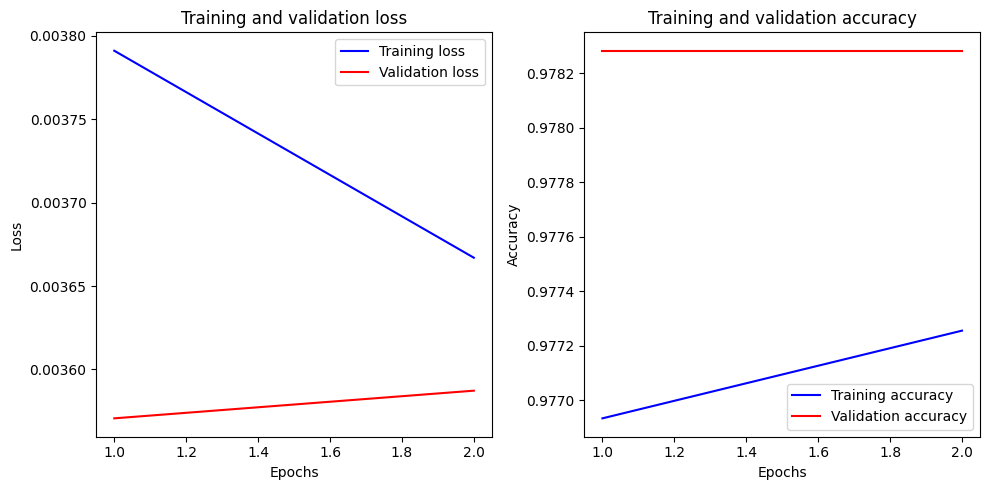

In [32]:
import matplotlib.pyplot as plt
# Graficar las curvas de pérdida y precisión
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



epochs = range(1, len(train_loss) + 1)

# Graficar las curvas de pérdida y precisión
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()